In [1]:
from skelm import LargeELMRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston, fetch_covtype
from sklearn.metrics import confusion_matrix
from tempfile import TemporaryDirectory
import pandas as pd
import numpy as np
import seaborn as sns

import dask.array as da
import dask.dataframe as dd

import warnings
warnings.filterwarnings("ignore", "the 'labels' keyword is deprecated")
warnings.filterwarnings("ignore", ".labels was deprecated in version 0.24.0")
warnings.filterwarnings("ignore", "The dimensionality of the problem will not be reduced.")

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
covtype = fetch_covtype()
X = pd.DataFrame(covtype.data)
Y = pd.get_dummies(covtype.target)

with TemporaryDirectory() as data_dir:
    nb = 150  # 8939
    X_files = [data_dir + "/X_{}.parquet".format(i) for i in range(nb)]
    y_files = [data_dir + "/y_{}.parquet".format(i) for i in range(nb)]
    for i in range(nb):
        z = X[i::nb]
        z.columns = ["f_"+str(c) for c in z.columns]
        z.to_parquet(fname=X_files[i])
        
        v = Y[i::nb]
        v.columns = ["cls_"+str(c) for c in v.columns]
        v.to_parquet(fname=y_files[i])

    # reduce data size
    X_files = X_files[::10]
    y_files = y_files[::10]    
    x_train, x_test, y_train, y_test = train_test_split(X_files, y_files, random_state=0)
    
    elm = LargeELMRegressor(
        alpha=1e+5,
        batch_size=2000, 
        n_neurons=10000-1,
        random_state=0
    )
    elm.fit(x_train, y_train, sync_every=1)

    yh_train = elm.predict(x_train).argmax(1)
    y1_train = dd.read_parquet(y_train).to_dask_array(lengths=True).argmax(1)
    cm_train = confusion_matrix(y1_train, yh_train)
    
    yh_test = elm.predict(x_test).argmax(1)
    y1_test = dd.read_parquet(y_test).to_dask_array(lengths=True).argmax(1)
    cm_test = confusion_matrix(y1_test, yh_test)
    

/Users/akusok/anaconda/envs/skelm/lib/python3.7/site-packages/pyarrow/pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)


Running on: <Client: scheduler='tcp://127.0.0.1:51152' processes=4 cores=4>
Dashboard at http://127.0.0.1:8787


/Users/akusok/anaconda/envs/skelm/lib/python3.7/site-packages/sklearn/random_projection.py:376: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (54 < 9999).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)


W dask.array<array, shape=(9999, 54), dtype=float64, chunksize=(2000, 54)>
XW dask.array<sum-aggregate, shape=(3873, 9999), dtype=float64, chunksize=(3873, 2000)>
H0 dask.array<tanh, shape=(3873, 9999), dtype=float64, chunksize=(3873, 2000)>
H_list
dask.array<tanh, shape=(3873, 9999), dtype=float64, chunksize=(3873, 2000)>
dask.array<ones, shape=(3873, 1), dtype=float64, chunksize=(3873, 1)>
H_dask dask.array<rechunk-merge, shape=(3873, 10000), dtype=float64, chunksize=(2000, 2000)>
HH dask.array<sum-aggregate, shape=(10000, 10000), dtype=float64, chunksize=(2000, 2000)>
HY dask.array<sum-aggregate, shape=(10000, 7), dtype=float64, chunksize=(2000, 7)>
XW dask.array<sum-aggregate, shape=(3874, 9999), dtype=float64, chunksize=(3874, 2000)>
H0 dask.array<tanh, shape=(3874, 9999), dtype=float64, chunksize=(3874, 2000)>
H_list
dask.array<tanh, shape=(3874, 9999), dtype=float64, chunksize=(3874, 2000)>
dask.array<ones, shape=(3874, 1), dtype=float64, chunksize=(3874, 1)>
H_dask dask.array<r

/Users/akusok/anaconda/envs/skelm/lib/python3.7/site-packages/distributed/worker.py:3165: UserWarning: Large object of size 4.32 MB detected in task graph: 
  (array([[ 0.01764141,  0.00400177,  0.00978787, .. ... 0.02015282]]),)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


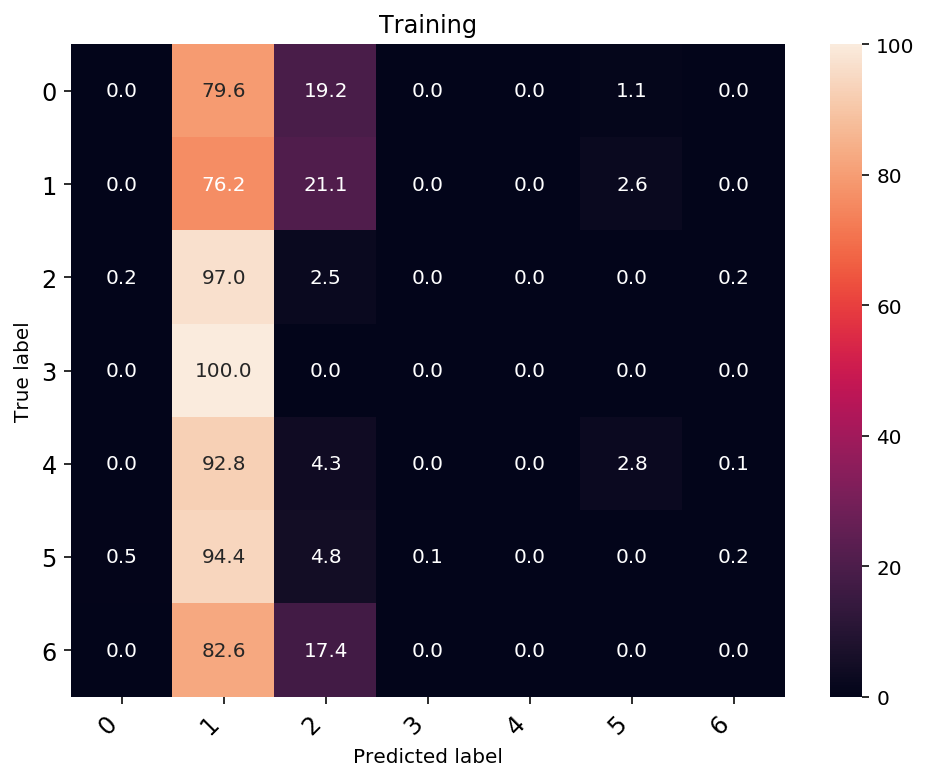

In [3]:
matplotlib.rcParams['figure.figsize'] = [8, 6]
cm = cm_train

heatmap = sns.heatmap(100 * cm / cm.sum(1)[:,None], annot=True, fmt=".1f")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
plt.title("Training")
plt.ylabel('True label')
_ =plt.xlabel('Predicted label')

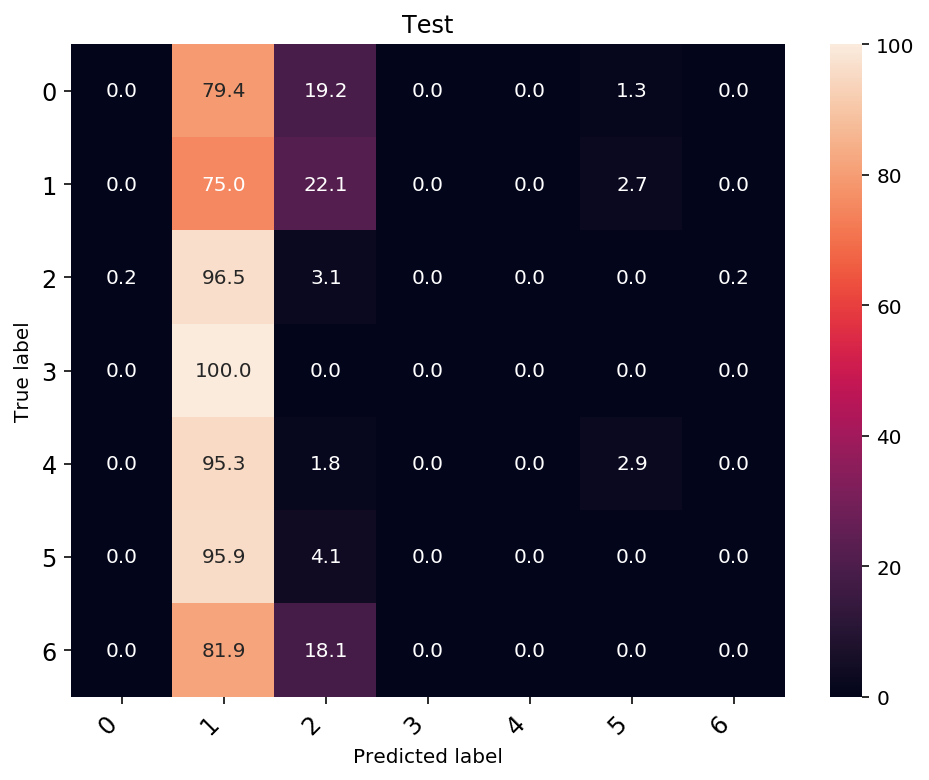

In [4]:
matplotlib.rcParams['figure.figsize'] = [8, 6]
cm = cm_test

heatmap = sns.heatmap(100 * cm / cm.sum(1)[:,None], annot=True, fmt=".1f")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
plt.title("Test")
plt.ylabel('True label')
_ = plt.xlabel('Predicted label')